# 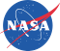 **NASA FIRMS - How to use FIRMS API in Python**

In this tutorial we will look into using FIRMS API to access up-to-date fire detections. We will cover:

- FIRMS MAP_KEY
- FIRMS API end points
- explain FIRMS datasets on how to use them

**Programming language:** Python

**Libraries:**  [pandas](https://pandas.pydata.org) & [requests](https://pypi.org/project/requests/)

---

**LEVEL:** Beginner

---


**Remember to execute code in order**

At first, let's look what API stands for. If it confuses you, don't worry, just try to follow our code examples and see if it becomes clearer to you.

**What is an API?**

APIs are mechanisms that enable two software components to communicate with each other using a set of definitions and protocols. For example, the weather bureau’s software system contains daily weather data. The weather app on your phone “talks” to this system via APIs and shows you daily weather updates on your phone.


**What does API stand for?**

API stands for Application Programming Interface. In the context of APIs, the word Application refers to any software with a distinct function. Interface can be thought of as a contract of service between two applications. This contract defines how the two communicate with each other using requests and responses. Their API documentation contains information on how developers are to structure those requests and responses.

*https://aws.amazon.com/what-is/api/*

To view current FIRMS API calls visit https://firms.modaps.eosdis.nasa.gov/api/.

In this tutorial we will explore these FIRMS API points:
- [area](https://firms.modaps.eosdis.nasa.gov/api/area)
- [countries](https://firms.modaps.eosdis.nasa.gov/api/countries)
- [country](https://firms.modaps.eosdis.nasa.gov/api/country)
- [data_availability](https://firms.modaps.eosdis.nasa.gov/api/data_availability)

---

## Get FIRMS API Key (MAP_KEY)

---

In order to provide access to FIRMS data, we require our users to sign up for a **FREE** API / map key (we call it: MAP_KEY).

The MAP_KEY was designed to conserve FIRMS resources, so everyone could have a reasonable access to our data. For example, a download script with an error could end up requesting too much data or query our database with high frequency.

FIRMS MAP_KEY was originally designed to facilitate only mapserver visualization queries, but now can be used for other requests. For example:

- Web Map Service (WMS)
- Web Feature Service (WFS)
- API

To sign up, visit https://firms.modaps.eosdis.nasa.gov/api/map_key

FIRMS MAP_KEY limits your usage to a 10-minute window. So if you exceed your limit, after 10 minutes, it resets so you can use the system again.

---

## Test Your MAP_KEY

---

In [2]:
# Let's set your map key that was emailed to you. It should look something like 'abcdef1234567890abcdef1234567890'
MAP_KEY = 'f6cd6de4fa5a42514a72c8525064e890'
# MAP_KEY = 'abcdef0123456789abcdef1234567890'

# now let's check how many transactions we have
import pandas as pd
import requests
url = 'https://firms.modaps.eosdis.nasa.gov/mapserver/mapkey_status/?MAP_KEY=' + MAP_KEY
try:
  response = requests.get(url)
  data = response.json()
  df = pd.Series(data)
  display(df)
except:
  # possible error, wrong MAP_KEY value, check for extra quotes, missing letters
  print ("There is an issue with the query. \nTry in your browser: %s" % url)


transaction_limit             5000
current_transactions             0
transaction_interval    10 minutes
dtype: object

In [3]:
# let's create a simple function that tells us how many transactions we have used.
# We will use this in later examples

def get_transaction_count() :
  count = 0
  try:
    response = requests.get(url)
    data = response.json()
    df = pd.Series(data)
    count = df['current_transactions']
  except:
    print ("Error in our call.")
  return count

tcount = get_transaction_count()
print ('Our current transaction count is %i' % tcount)

Our current transaction count is 0


---

## API/data_availability

---

This service is designed to inform users about date range availability of our supported datasets.

For more information visit https://firms.modaps.eosdis.nasa.gov/api/data_availability

Let's see the full list of available sensors and their supported date ranges.


In [4]:
# let's query data_availability to find out what date range is available for various datasets
# we will explain these datasets a bit later

# this url will return information about all supported sensors and their corresponding datasets
# instead of 'all' you can specify individual sensor, ex:LANDSAT_NRT
da_url = 'https://firms.modaps.eosdis.nasa.gov/api/data_availability/csv/' + MAP_KEY + '/all'
df = pd.read_csv(da_url)
display(df)

,data_id,min_date,max_date
0,MODIS_NRT,2025-08-01,2025-11-07
1,MODIS_SP,2000-11-01,2025-07-31
2,VIIRS_NOAA20_NRT,2025-08-01,2025-11-07
3,VIIRS_NOAA20_SP,2018-04-01,2025-07-31
4,VIIRS_NOAA21_NRT,2024-01-17,2025-11-07
5,VIIRS_SNPP_NRT,2025-08-01,2025-11-07
6,VIIRS_SNPP_SP,2012-01-20,2025-07-31
7,LANDSAT_NRT,2022-06-20,2025-10-21
8,GOES_NRT,2022-08-09,2025-11-07
9,BA_MODIS,2000-11-01,2025-08-01


**data_id** column shows the dataset id which we will need in later queries:
- 'NRT' means this is Near Real-Time dataset but it may also includes Real Time (RT) and Ultra Real Time (URT) data [click here more info on URT/RT](https://www.earthdata.nasa.gov/data/tools/firms/faq)
- 'SP' or Standard Processing; standard data products are an internally consistent, well-calibrated record of the Earth’s geophysical properties to support science. There is a multi-month lag in this dataset availability. [more information on SP vs NRT](https://www.earthdata.nasa.gov/data/tools/firms/faq)
- BA_MODIS is for MODIS burned areas product

**min_date** and **max_date** columns provide the available date range for these datasets. Dates are based on GMT

In [5]:
# now let's see how many transactions we use by querying this end point

start_count = get_transaction_count()
pd.read_csv(da_url)
end_count = get_transaction_count()
print ('We used %i transactions.' % (end_count-start_count))

# now remember, after 10 minutes this will reset

We used 5 transactions.


---

## API/area

---

Fire detection hotspots based on area, date and sensor. For more information visit https://firms.modaps.eosdis.nasa.gov/api/area

The end point expects these parameters: [MAP_KEY], [SOURCE], [AREA_COORDINATES],[DAY_RANGE] and optionally [DATE] for historical data

**NOTE** - querying the entire world for VIIRS can return between 30,000 - 100,000+ records per day


In [6]:
# in this example let's look at VIIRS NOAA-20, entire world and the most recent day
area_url = 'https://firms.modaps.eosdis.nasa.gov/api/area/csv/' + MAP_KEY + '/VIIRS_NOAA20_NRT/world/1'
start_count = get_transaction_count()
df_area = pd.read_csv(area_url)
end_count = get_transaction_count()
print ('We used %i transactions.' % (end_count-start_count))

df_area

We used 36 transactions.


,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_ti5,frp,daynight
0,31.18588,36.07341,308.27,0.33,0.55,2025-11-07,0,N20,VIIRS,n,2.0NRT,289.39,0.89,N
1,31.33561,36.12973,297.31,0.33,0.55,2025-11-07,0,N20,VIIRS,n,2.0NRT,284.74,0.72,N
2,32.21597,36.20008,301.59,0.32,0.54,2025-11-07,0,N20,VIIRS,n,2.0NRT,287.44,1.65,N
3,32.88923,35.09256,303.76,0.53,0.50,2025-11-07,0,N20,VIIRS,n,2.0NRT,290.84,1.28,N
4,33.59159,42.50275,305.29,0.66,0.73,2025-11-07,0,N20,VIIRS,n,2.0NRT,285.66,1.90,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11280,9.76210,-73.47741,315.33,0.50,0.50,2025-11-07,653,N20,VIIRS,n,2.1URT,290.24,1.67,N
11281,9.76671,-73.47657,305.38,0.50,0.50,2025-11-07,653,N20,VIIRS,n,2.1URT,290.01,1.67,N
11282,10.29297,-71.38081,301.22,0.40,0.60,2025-11-07,653,N20,VIIRS,n,2.1URT,281.48,0.38,N
11283,4.31032,-75.09942,308.14,0.50,0.50,2025-11-07,654,N20,VIIRS,n,2.1URT,288.00,1.84,N


In [7]:
# We can also focus on a smaller area ex. South Asia and get the last 3 days of records
area_url = 'https://firms.modaps.eosdis.nasa.gov/api/area/csv/' + MAP_KEY + '/VIIRS_NOAA20_NRT/54,5.5,102,40/3'
df_area = pd.read_csv(area_url)
df_area

,latitude,longitude,bright_ti4,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_ti5,frp,daynight
0,5.56310,95.66557,332.25,0.48,0.40,2025-11-05,646,N20,VIIRS,n,2.0NRT,296.66,4.39,D
1,8.93893,99.09568,330.96,0.39,0.36,2025-11-05,646,N20,VIIRS,n,2.0NRT,291.15,2.29,D
2,19.71535,101.36639,333.11,0.41,0.45,2025-11-05,650,N20,VIIRS,n,2.0NRT,291.64,4.87,D
3,19.98971,81.92285,328.61,0.68,0.74,2025-11-05,650,N20,VIIRS,n,2.0NRT,292.68,4.20,D
4,20.75784,85.30004,329.38,0.40,0.60,2025-11-05,650,N20,VIIRS,l,2.0NRT,304.27,6.15,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4220,18.03636,54.64013,314.39,0.47,0.48,2025-11-06,2224,N20,VIIRS,n,2.0NRT,290.21,7.47,N
4221,18.31918,55.10517,301.87,0.49,0.49,2025-11-06,2224,N20,VIIRS,n,2.0NRT,288.20,1.98,N
4222,18.32009,55.10059,329.08,0.49,0.49,2025-11-06,2224,N20,VIIRS,n,2.0NRT,289.30,3.63,N
4223,18.32071,55.10302,325.51,0.49,0.49,2025-11-06,2224,N20,VIIRS,n,2.0NRT,289.96,3.06,N


---

## API/countries

---

List of supported countries and their 3-letter codes. This may be easier to read in html format https://firms.modaps.eosdis.nasa.gov/api/countries/?format=html however, you won't be able to see the exent box defined for each country.

Example below shows how you can view from Python.

In [9]:
# We can also focus on smaller area ex. South Asia and get last 3 days of records
countries_url = 'https://firms.modaps.eosdis.nasa.gov/api/countries'
df_countries = pd.read_csv(countries_url, sep=';')
df_countries

,Invalid API call.


---

## API/country

---

Provides data specific to a country, although not recommended for large countries such as USA, China, Canada, Russia due to the complexity and size of their polygon shape which may cause the query to time out. To figure out the country code, see [/api/countries](https://firms.modaps.eosdis.nasa.gov/api/countries/?format=html) (example above).

In [ ]:
# Let's see last four days MODIS data for Peru
peru_url = 'https://firms.modaps.eosdis.nasa.gov/api/country/csv/' + MAP_KEY + '/MODIS_NRT/PER/4'
df_peru = pd.read_csv(peru_url)
df_peru

,country_id,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight
0,PER,-6.99466,-76.58813,311.65,1.03,1.02,2025-06-03,236,Terra,MODIS,83,6.1NRT,292.65,10.58,N
1,PER,-6.99336,-76.57896,306.93,1.03,1.02,2025-06-03,236,Terra,MODIS,70,6.1NRT,292.46,7.20,N
2,PER,-7.17989,-78.49985,302.92,2.56,1.54,2025-06-03,1459,Terra,MODIS,23,6.1NRT,290.50,13.36,D
3,PER,-7.37492,-79.47012,315.60,1.12,1.06,2025-06-03,2012,Aqua,MODIS,48,6.1NRT,297.68,7.25,D
4,PER,-7.32809,-79.45269,318.11,1.12,1.06,2025-06-03,2012,Aqua,MODIS,71,6.1NRT,296.82,11.74,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,PER,-6.97812,-77.78459,304.40,1.05,1.03,2025-06-05,1951,Aqua,MODIS,29,6.1NRT,288.96,6.94,D
70,PER,-6.89843,-76.79227,314.17,1.00,1.00,2025-06-05,1951,Aqua,MODIS,72,6.1NRT,299.94,6.28,D
71,PER,-4.71203,-80.52554,328.20,1.39,1.17,2025-06-05,1951,Aqua,MODIS,81,6.1NRT,297.56,30.36,D
72,PER,-4.71032,-80.51339,316.20,1.38,1.16,2025-06-05,1951,Aqua,MODIS,59,6.1NRT,296.18,10.00,D


---

## FIRMS Datasets

---

As you may have seen when looking at data_availability there are following available datasets:

- LANDSAT_NRT **US/Canada only** [data attributes](https://www.earthdata.nasa.gov/data/tools/firms/faqs)
- MODIS_NRT [data attributes](https://www.earthdata.nasa.gov/learn/find-data/near-real-time/firms/mcd14dl-nrt#ed-firms-attributes)
- MODIS_SP [data attributes](https://www.earthdata.nasa.gov/learn/find-data/near-real-time/firms/mcd14dl-nrt#ed-firms-attributes)
- VIIRS_NOAA20_NRT [data attributes](https://www.earthdata.nasa.gov/learn/find-data/near-real-time/firms/vnp14imgtdlnrt#ed-viirs-375m-attributes)
- VIIRS_SNPP_NRT [data attributes](https://www.earthdata.nasa.gov/learn/find-data/near-real-time/firms/vnp14imgtdlnrt#ed-viirs-375m-attributes)
- VIIRS_SNPP_SP [data attributes](https://www.earthdata.nasa.gov/learn/find-data/near-real-time/firms/vnp14imgtdlnrt#ed-viirs-375m-attributes)

**NRT**: dataset consists of (Near Real-Time, Real-Time and Ultra Real-Time) data. [view details on RT and URT](https://www.earthdata.nasa.gov/data/tools/firms/faq). Also explore our blog: [Wildfire detection in the US and Canada within a minute of satellite observation](https://wiki.earthdata.nasa.gov/display/FIRMS/2022/07/14/Wildfire+detection+in+the+US+and+Canada+within+a+minute+of+satellite+observation)

**SP**: Standard Processing; standard data products are an internally consistent, well-calibrated record of the Earth’s geophysical properties to support science. There is a multi-month lag in this dataset availability. [more information on SP vs NRT](https://www.earthdata.nasa.gov/data/tools/firms/faq)

---

## Summary

---

Thank you for taking time to go over the tutorial. We hope you enjoyed it and if you have any questions or comments please use the 'Feedback' form at the top of our site [firms.modaps.eosdis.nasa.gov](https://firms.modaps.eosdis.nasa.gov)